In [21]:
using LowRankModels, DataFrames, Gadfly, Plotly
include("proxgrad.jl");

In [22]:
training = readtable("train.csv")
training[:Month] = DateTime(training[:Month],"yyyy-mm-ddTHH:MM:SS")
testing = readtable("test.csv")
testing[:Month] = DateTime(testing[:Month],"yyyy-mm-ddTHH:MM:SS");

In [23]:
DBurglary = training[training[:Text_General_Code].=="Burglary",:]
head(DBurglary)

,Month,Text_General_Code,x1,Year,Unemployment,Child_mortality,hospital_ambulization_rate,Cancer_mortality,Days_good_air_quality,Homicide_mortality_rate,Suicide_mortality_rate,Theft,All_Other_Offenses,Other_Assaults,Vandalism,Narcotic,Burglary,Fraud,Retrieving,Robbery,Aggravated_Assault,Driving_Under_The_Influcence,Disorderly_Conduct,Weapon_Violations,Other_Sex_Offenses,Prostitution,Rape,Drinking_Violation,Vagrancy_Loitering,Arson,Forgery_Counterfeiting,Embezzlement,Homicide,Offenses_Against_Family_Children,Gambling_Violations,Receiving_Stolen_Property,Temperature_Max,Temperature_Min,Temperature_Avg,Temperature_Departure,HDD,CDD,Precipitation,New_Snow,Snow_Depth
1,2006-01-01T00:00:00,Burglary,906,2006,0.062,87.5,1608.9,228.1,154,24.4,9.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49.12903226,32.35483871,40.74193548,7.793548387,23.96774194,0.0,0.14,0.012903226,0.0
2,2006-02-01T00:00:00,Burglary,673,2006,0.062,87.5,1608.9,228.1,154,24.4,9.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43.42857143,27.78571429,35.60714286,-0.15,29.14285714,0.0,0.053928571,0.428571429,0.964285714
3,2006-03-01T00:00:00,Burglary,842,2006,0.062,87.5,1608.9,228.1,154,24.4,9.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53.4516129,35.5483871,44.5,0.94516129,20.25806452,0.032258065,0.029354839,0.0,0.0
4,2006-04-01T00:00:00,Burglary,781,2006,0.062,87.5,1608.9,228.1,154,24.4,9.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67.03333333,46.26666667,56.65,2.646666667,8.366666667,0.366666667,0.123666667,0.003333333,0.0
5,2006-05-01T00:00:00,Burglary,996,2006,0.062,87.5,1608.9,228.1,154,24.4,9.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74.83870968,54.25806452,64.5483871,0.648387097,2.64516129,2.451612903,0.069677419,0.0,0.0
6,2006-06-01T00:00:00,Burglary,921,2006,0.062,87.5,1608.9,228.1,154,24.4,9.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80.9,64.66666667,72.78333333,-0.466666667,0.066666667,8.0,0.265,0.0,0.0


In [24]:
ncol(DBurglary)

45

# Model 1: Offset and Temperature

In [25]:
n = nrow(DBurglary)
X₁ = [ones(n) DBurglary[:Temperature_Avg].data]
y₁ = DBurglary[:x1].data
w₁ = X₁\y₁;

# Model 2: Offset, Temperature, Year Before

In [26]:
year_later = DBurglary[:x1][13:end]
year_before = DBurglary[:x1][1:(end-12)]
n₂ = size(year_later)
X₂ = [ones(n₂) DBurglary[:Temperature_Avg].data[13:end] year_before.data]
y₂ = year_later.data
w₂ = X₂\y₂;

# Model 3: Offset, Temperature, Unemployment, Good Air Quality

In [27]:
X₃= [ones(n) DBurglary[:Temperature_Avg].data DBurglary[:Unemployment].data DBurglary[:Days_good_air_quality].data]
y₃ = DBurglary[:x1].data
w₃ = X₃\y₃;

# Model 4: Using Everything in Dataset

In [28]:
p = (DBurglary[:, 4:end])
p2 = Array([p[:, 1:8] p[:, 34:end]]) # excludes boolean values for the different crimes
X₄= [ones(n) p2]
y₄ = DBurglary[:x1].data
w₄ = X₄\y₄;

In [29]:
Dmodels1 = DBurglary[:,3:3]
Dmodels2 = DBurglary[:,1:1]
Dmodels = [Dmodels2 Dmodels1]
Dmodels[:m1] =  X₁*w₁
Dmodels[:m2] =  vcat(Dmodels[:m1][1:12],X₂*w₂)
Dmodels[:m3] =  X₃*w₃
Dmodels[:m4] =  X₄*w₄;

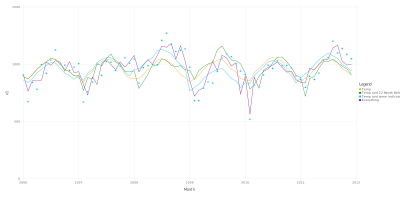

In [30]:
set_default_plot_size(40cm,20cm)
Gadfly.plot(Dmodels,x=:Month,y=:x1,
Geom.point,layer(x=:Month,y=:m1,Geom.line,Theme(default_color=colorant"orange")),
layer(x=:Month,y=:m2,Geom.line,Theme(default_color=colorant"green")),
layer(x=:Month,y=:m3,Geom.line,Theme(default_color=colorant"deepskyblue")),
layer(x=:Month,y=:m4,Geom.line,Theme(default_color=colorant"purple")),
Guide.manual_color_key("Legend", ["Temp", "Temp and 12 Month Before","Temp and some Indicators", "Everything"], ["orange", "green", "deepskyblue", "purple"]))

In [31]:
# Calculate Errors: We can see that the Everything data model has the lowest error
err_temp(X,y,w) = sum((y-X*w).^2)
y = DBurglary[:x1].data
[err_temp(X₁,y,w₁) err_temp(X₂,y₂,w₂)  err_temp(X₃,y,w₃)  err_temp(X₄,y,w₄)]

1×4 Array{Float64,2}:
 1.04137e6  734210.0  8.42284e5  3.81552e5

# Looking at Model 4 with Loss Functions using proxgrad_linesearch

In [32]:
xL = svd(X₄)[2][1]
L = 1/(2*xL^2)
X₄ = convert(Array{Float64, 2},X₄)
w41 = proxgrad_linesearch(QuadLoss(), ZeroReg(), X₄, y₄; stepsize = L, maxiters = 100000)
w42 = proxgrad_linesearch(L1Loss(), ZeroReg(), X₄, y₄; stepsize = L, maxiters = 1000000)
w43 = proxgrad_linesearch(HuberLoss(), ZeroReg(), X₄, y₄; stepsize = L, maxiters = 1000000)
Dmodels[:m41] =  X₄*w41
Dmodels[:m42] =  X₄*w42
Dmodels[:m43] =  X₄*w43

# To see if Regularizer helps with Huber Loss
w422 = proxgrad_linesearch(HuberLoss(), QuadReg(2), X₄, y₄; stepsize = L, maxiters = 1000000)
Dmodels[:m422] =  X₄*w422;

#@show w41
#@show w42;

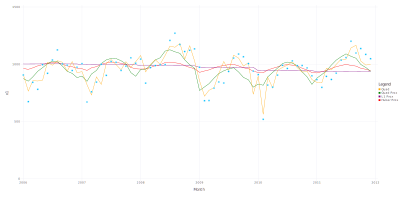

In [33]:
Gadfly.plot(Dmodels,x=:Month,y=:x1,
Geom.point,layer(x=:Month,y=:m4,Geom.line,Theme(default_color=colorant"orange")),
layer(x=:Month,y=:m41,Geom.line,Theme(default_color=colorant"green")),
layer(x=:Month,y=:m42,Geom.line,Theme(default_color=colorant"purple")),
layer(x=:Month,y=:m43,Geom.line,Theme(default_color=colorant"red")),
Guide.manual_color_key("Legend", ["Quad", "Quad Prox","L1 Prox", "Huber Prox"], ["orange", "green", "purple", "red"]))

In [34]:
mse(y,X,w) = sum((y-X*w).^2)/length(y)

@show mse(y, 1, Dmodels[:m4])  # QR Factoriztion
@show mse(y, 1, Dmodels[:m41]) # Prox Grad Quad Loss
@show mse(y, 1, Dmodels[:m42]) # Prox Grad L1 Loss
@show mse(y, 1, Dmodels[:m43]) # Prox Grad Huber Loss

mse(y,1,Dmodels[:m4]) = 5299.327298733878
mse(y,1,Dmodels[:m41]) = 11300.168638399839
mse(y,1,Dmodels[:m42]) = 19426.180105074036
mse(y,1,Dmodels[:m43]) = 16231.340389851066


16231.340389851066

# Looking at Model 4 with Quad Loss and a Regularizer

In [35]:
# TO DO: Set a large coefficient for regularizer
xL = svd(X₄)[2][1]
L = 1/(2*xL^2)
X₄ = convert(Array{Float64, 2},X₄)
w44 = proxgrad_linesearch(QuadLoss(), QuadReg(2), X₄, y₄; stepsize = L, maxiters = 100000)
w45 = proxgrad_linesearch(QuadLoss(), QuadConstraint(2), X₄, y₄; stepsize = L, maxiters = 100000)
w46 = proxgrad_linesearch(QuadLoss(), OneReg(2), X₄, y₄; stepsize = L, maxiters = 100000)
w47 = proxgrad_linesearch(QuadLoss(), OneSparseConstraint(), X₄, y₄; stepsize = L, maxiters = 100000)
Dmodels[:m44] =  X₄*w44
Dmodels[:m45] =  X₄*w45
Dmodels[:m46] =  X₄*w46
Dmodels[:m47] =  X₄*w47;

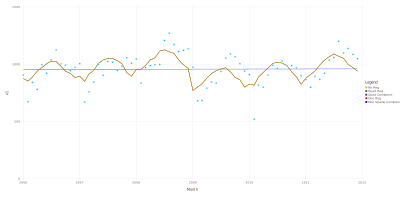

In [36]:
Gadfly.plot(Dmodels,x=:Month,y=:x1,
Geom.point,layer(x=:Month,y=:m41,Geom.line,Theme(default_color=colorant"orange")),
layer(x=:Month,y=:m44,Geom.line,Theme(default_color=colorant"green")),
layer(x=:Month,y=:m45,Geom.line,Theme(default_color=colorant"purple")),
layer(x=:Month,y=:m46,Geom.line,Theme(default_color=colorant"red")),
layer(x=:Month,y=:m47,Geom.line,Theme(default_color=colorant"blue")),
Guide.manual_color_key("Legend", ["No Reg", "Quad Reg","Quad Constraint", "One Reg", "One Sparse Constraint"], ["orange", "green", "purple", "red", "blue"]))

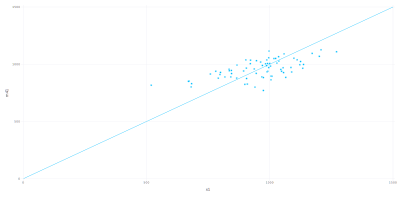

In [37]:
Gadfly.plot(Dmodels,x=:x1,y=:m41, Geom.point, layer(x=collect(1:1500),y=collect(1:1500),Geom.line))

# Looking at Model 4 with Huber Loss and a Regularizer

### Huber Loss actually doesn't even compare with Quad loss and their different regularizers

In [38]:
xL = svd(X₄)[2][1]
L = 1/(2*xL^2)
X₄ = convert(Array{Float64, 2},X₄)
whuber1 = proxgrad_linesearch(HuberLoss(), QuadReg(2), X₄, y₄; stepsize = L, maxiters = 100000)
whuber2 = proxgrad_linesearch(HuberLoss(), QuadConstraint(2), X₄, y₄; stepsize = L, maxiters = 100000)
whuber3 = proxgrad_linesearch(HuberLoss(), OneReg(2), X₄, y₄; stepsize = L, maxiters = 100000)
Dmodels[:mhuber1] =  X₄*whuber1
Dmodels[:mhuber2] =  X₄*whuber2
Dmodels[:mhuber3] =  X₄*whuber3;

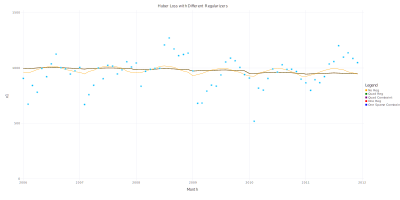

In [39]:
Gadfly.plot(Dmodels,x=:Month,y=:x1,
Geom.point,layer(x=:Month,y=:m43,Geom.line,Theme(default_color=colorant"orange")),
layer(x=:Month,y=:mhuber1,Geom.line,Theme(default_color=colorant"green")),
layer(x=:Month,y=:mhuber2,Geom.line,Theme(default_color=colorant"purple")),
layer(x=:Month,y=:mhuber3,Geom.line,Theme(default_color=colorant"red")),
Guide.title("Huber Loss with Different Regularizers"),
Guide.manual_color_key("Legend", ["No Reg", "Quad Reg","Quad Constraint", "One Reg", "One Sparse Constraint"], ["orange", "green", "purple", "red", "blue"]))

# Looking at Model 4 with L1 Loss and a Regularizer

In [40]:
#...

# Test set see MSE

In [41]:
# MUST REDO
Dtest = testing[testing[:Text_General_Code].=="Burglary",:]
Dmodels1 = Dtest[:,3:3]
Dmodels2 = Dtest[:,1:1]
DmodelsTest = [Dmodels2 Dmodels1]
n = nrow(Dtest)
p = (Dtest[:, 4:end])
p2 = Array([p[:, 1:8] p[:, 34:end]]) # excludes boolean values for the different crimes
Xtest= [ones(n) p2]
DmodelsTest[:m4] =   Xtest*w₄
DmodelsTest[:m41] =  Xtest*w41
DmodelsTest[:m42] =  Xtest*w42
DmodelsTest[:m43] =  Xtest*w43
DmodelsTest[:m44] =  Xtest*w44
DmodelsTest[:m45] =  Xtest*w45
DmodelsTest[:m46] =  Xtest*w46
DmodelsTest[:m47] =  Xtest*w47;

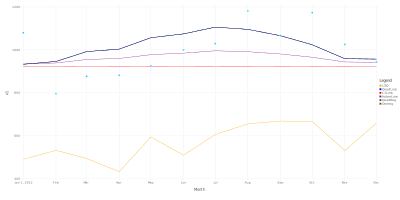

In [42]:
Gadfly.plot(DmodelsTest,x=:Month,y=:x1,
Geom.point,layer(x=:Month,y=:m4,Geom.line,Theme(default_color=colorant"orange")),
layer(x=:Month,y=:m41,Geom.line,Theme(default_color=colorant"blue")),
layer(x=:Month,y=:m42,Geom.line,Theme(default_color=colorant"red")),
layer(x=:Month,y=:m43,Geom.line,Theme(default_color=colorant"purple")),
layer(x=:Month,y=:m44,Geom.line,Theme(default_color=colorant"green")),
layer(x=:Month,y=:m46,Geom.line,Theme(default_color=colorant"brown")),
Guide.manual_color_key("Legend", ["LSQ", "QuadLoss", "L1Loss", "HuberLoss", "QuadReg", "Onereg"], ["orange", "blue", "red", "purple", "green", "brown"]))

# Quad Loss no Regularizer, Quad Loss with Quad Regularizer, and Quad Loss with One Regularizer produces the best prediction out of the other models created

In [43]:
DmodelsTest[:mhuber1] =  Xtest*whuber1
DmodelsTest[:mhuber2] =  Xtest*whuber2
DmodelsTest[:mhuber3] =  Xtest*whuber3

Gadfly.plot(DmodelsTest,x=:Month,y=:x1,
Geom.point,layer(x=:Month,y=:m41,Geom.line,Theme(default_color=colorant"orange")),
layer(x=:Month,y=:m43,Geom.line,Theme(default_color=colorant"blue")),
layer(x=:Month,y=:mhuber1,Geom.line,Theme(default_color=colorant"red")),
layer(x=:Month,y=:mhuber2,Geom.line,Theme(default_color=colorant"purple")),
layer(x=:Month,y=:mhuber3,Geom.line,Theme(default_color=colorant"green")),
Guide.manual_color_key("Legend", ["QuadLoss", "HuberLoss", "Huber&QuadReg", "Huber&QuadConst", "Huber&l1Reg"], ["orange", "blue", "red", "purple", "green"]))

### CLEARLY, Huber is not what we want compared to Quad Loss in proximal gradient

# Computing MSE

In [44]:
Ytest = DmodelsTest[:x1]
mse(y,X,w) = sum((y-X*w).^2)/length(y)
wVector = [w41, w42, w43, w44, whuber1, whuber3]
for i in wVector
    println(mse(Ytest, Xtest, i))
end
xTest₁ = [ones(n) Dtest[:Temperature_Avg].data]
mse(Ytest,xTest₁, w₁)

11301.523395692873
18482.671002466468
12625.350492020603
11301.360453022366
16017.911982104904
16018.093269978388


12104.564875169026

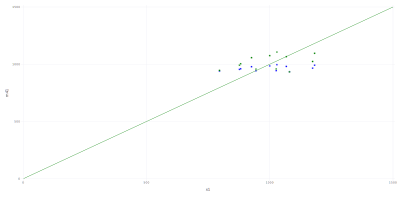

In [45]:
Gadfly.plot(DmodelsTest,x=:x1,y=:m41, Geom.point, Theme(default_color=colorant"green"),
layer(x=collect(1:1500),y=collect(1:1500),Geom.line),
layer(x=:x1,y=:m43,Geom.point, Theme(default_color=colorant"blue")))

# Failed Attempt at Using Random Forests

In [46]:
Pkg.add("DecisionTree")
using DecisionTree

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of DecisionTree
INFO: Use `Pkg.update()` to get the latest versions of your packages


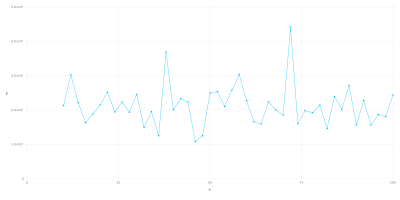

In [47]:
# Set i to what you want to control, either the nubmer of features OR the number of trees
d = collect(10:2:100)
v = []
for i in d
    forest =  build_forest(y₄, X₄, 9, i, 1.0)
    predTest = apply_forest(forest, Xtest)
    m = mse(Ytest, 1, predTest)
    push!(v, m)
end
Gadfly.plot( x=d,y=v, Geom.point, Geom.line)
# Concluded Analysis shows 9 features and 33 trees, but doesn't make sense so I don't think this package works...

In [48]:
model = build_forest(y₄, X₄, 9, 33, 1.0)
predTest = apply_forest(model, Xtest)
DmodelsTest[:randomModel] = predTest

12-element Array{Any,1}:
  909
 1045
 1086
  988
  922
  922
 1058
 1029
 1172
  989
  683
 1134

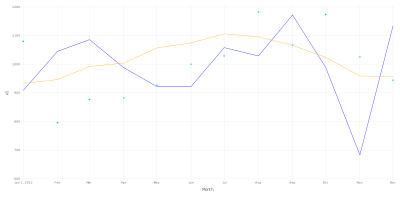

In [49]:
Gadfly.plot(DmodelsTest,x=:Month,y=:x1,
Geom.point,layer(x=:Month,y=:m41,Geom.line,Theme(default_color=colorant"orange")),
layer(x=:Month,y=:randomModel,Geom.line,Theme(default_color=colorant"blue")))


In [50]:
@show mse(Ytest, Xtest, w41)
@show mse(Ytest, 1, predTest)
# Comparing MSE, the quad loss prox grad with no regularizer tests better than random forest

mse(Ytest,Xtest,w41) = 11301.523395692873
mse(Ytest,1,predTest) = 31292.333333333332


31292.333333333332

In [51]:
predTrain = apply_forest(model, X₄)
@show mse(y, X₄, w41)
@show mse(y, 1, predTest)

mse(y,X₄,w41) = 11300.168638399839


LoadError: LoadError: DimensionMismatch("dimensions must match")
while loading In[51], in expression starting on line 218